# Two Dots Dataset

Generate a dataset of white images 32x32 containing two red dots at random distance (uniform).

In [1]:
import numpy as np
import os
import torch

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
image_size = 32
n_channels = 3
margin = 3
output_directory = "dataset"
os.makedirs(output_directory, exist_ok=True)

4.546066096307157


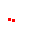

In [4]:
from PIL import Image, ImageDraw

def draw_point(draw, center, radius, color="red"):
    draw.ellipse((center[0] - radius, center[1] - radius, center[0] + radius, center[1] + radius), color)

def generate_image(image_size, radius=1, margin=3):
    """
    Create an image with 2 red dots
    returns: image, distance between points
    """
    x = np.random.rand(2) * (image_size - 2 * margin) + margin
    y = np.random.rand(2) * (image_size - 2 * margin) + margin
    dist = np.linalg.norm(x - y)
    
    img = Image.new("RGB", [image_size, image_size], (255, 255, 255))
    draw = ImageDraw.Draw(img)
    draw_point(draw, x, radius)
    draw_point(draw, y, radius)
    return img, dist
    
img, dist = generate_image(32)
print(dist)
img

In [5]:
def resampling_uniform_indices(values, num_samples, min_=None, max_=None):
    sorted_indices = values.argsort()
    
    min_ = min_ or min(values)
    max_ = max_ or max(values)
    linspace = np.linspace(min_, max_, num_samples)

    indices = []
    i = 0
    for threshold in linspace:
        while i < len(sorted_indices) and values[sorted_indices[i]] < threshold:
            i += 1
        if i >= len(sorted_indices):
            break
        else:
            indices.append(sorted_indices[i])
            i += 1
        
    return np.array(indices)

In [6]:
# DATASET:
# Train and valid with dist [5,19]
# 4000 train, 1000 valid
# Test with dist [5 25]
# 5000 test
# Classes are always balanced

def generate_dataset(n, min_dist, max_dist, image_size, class_1_threshold):
    images, distances = zip(*[generate_image(image_size) for _ in range(100 * n)])
    distances = np.array(distances)
    resampled_indices = resampling_uniform_indices(distances, n, min_=min_dist, max_=max_dist)
    np.random.shuffle(resampled_indices)
    images = [images[i] for i in resampled_indices]
    distances = distances[resampled_indices]
    return images, (distances > class_1_threshold) * 1

class_1_threshold = 12
train = generate_dataset(4000, 5, 19, 32, class_1_threshold=class_1_threshold)
valid = generate_dataset(1000, 5, 19, 32, class_1_threshold=class_1_threshold)

n_test = 5000
images_test0, distances_test0 = generate_dataset(n_test // 2, 5, class_1_threshold, 32, class_1_threshold=class_1_threshold)
images_test1, distances_test1 = generate_dataset(n_test // 2, class_1_threshold, 25, 32, class_1_threshold=class_1_threshold)
test = images_test0 + images_test1, np.concatenate([distances_test0, distances_test1])
# test = generate_dataset(5000, 5, 25, 32, class_1_threshold=class_1_threshold)

In [32]:
def save_dataset(images, labels, directory, split):
    def torch_image_from_PIL(im):
        # numpy
        im = np.asarray(im)
        # in [0, 1]
        im = (im * 1.) / 255.
        # to pytorch
        im = torch.from_numpy(im)
        # dim order CWH
        im = im.permute(2, 0, 1)
        return im
    
    images = [torch_image_from_PIL(im) for im in images]
    labels = torch.from_numpy(labels * 1)
    
    x_shape = [len(images), *(images[0].shape)]
    x = torch.zeros(x_shape)
    for i in range(len(images)):
        x[i] = images[i]
    filename = os.path.join(directory, "two_dots_balanced.{}".format(split))
    torch.save({'data': x, 'target': labels}, filename)

save_dataset(train[0], train[1], output_directory, "train")
save_dataset(valid[0], valid[1], output_directory, "valid")
save_dataset(test[0], test[1], output_directory, "test")

In [33]:
train_data = torch.load("dataset/two_dots_balanced.train")
images = train_data["data"]
labels = train_data["target"]

label 0


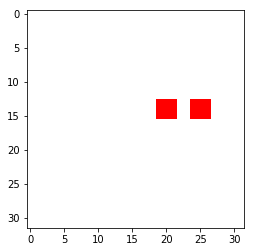

label 0


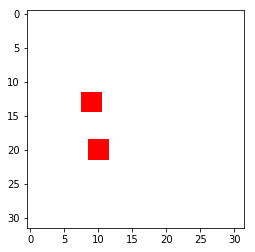

label 0


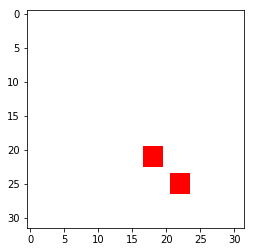

label 1


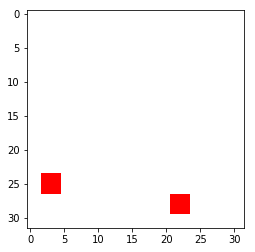

label 1


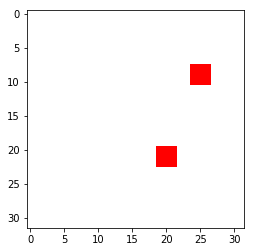

label 1


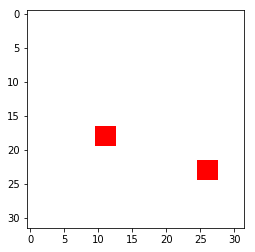

label 0


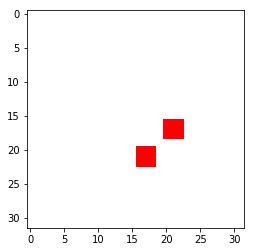

label 0


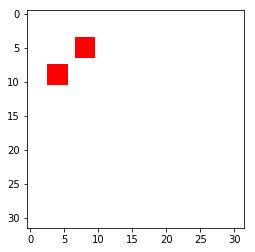

label 0


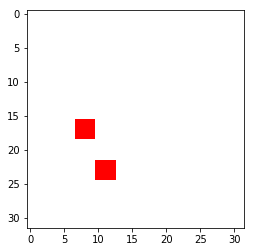

label 1


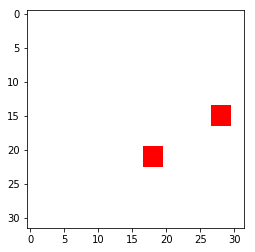

In [39]:
for i in range(10):
    print("label", labels[i].item())
    plt.figure()
    plt.imshow(images[i].permute(1,2,0).numpy())
    plt.show();